# **Import Libraries and Dataset**

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('healthcare_sales_dataset.csv')

# **Exploratory Data Analysis**

In [3]:
df.head()

,product_id,company_id,transaction_id,product_name,product_category,sale_amount,quantity_sold,price_per_unit,uom,address,region,customer_segment,sales_rep_name,date_of_sale,multiple_items
0,PMFTMGPWLK,hospital_20,KH9NHAKRFF,Gauze Sponges,Medical Devices,463.07,85,5.45,packs,"Washington, DC",Northeast,Hospital,Christopher Flores,8/5/2024,0
1,B2L09J6I8B,clinic_3,6XGV4E1D36,Scalpel Blades,Surgical Supplies,387.87,12,32.32,pieces,"Chicago, IL",Midwest,Clinic,John Ponce,4/22/2024,1
2,TLJFSQ5K16,clinic_10,OGEAMK0FW0,Disposable Gloves,Medical Devices,336.95,26,12.96,boxes,"Minneapolis, MN",Midwest,Clinic,Thomas Silva,9/30/2024,1
3,3BDN23AHDX,hospital_2,Y68IXY4B8S,"Syringes, 50ml",Surgical Supplies,254.99,17,15.00,boxes,"Boston, MA",Northeast,Hospital,Megan Chang,5/20/2024,0
4,3BDN23AHDX,clinic_8,3GU73WIOON,"Syringes, 50ml",Medical Devices,291.24,66,4.41,boxes,"Los Angeles, CA",West,Clinic,William Sullivan,5/13/2024,1


In [6]:
df.dtypes

,0
product_id,object
company_id,object
transaction_id,object
product_name,object
product_category,object
sale_amount,float64
quantity_sold,int64
price_per_unit,float64
uom,object
address,object


In [4]:
df.describe()

,sale_amount,quantity_sold,price_per_unit,multiple_items
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,248.864717,40.619700,9.648196,0.725800
std,135.647920,21.914851,13.229527,0.446133
min,10.060000,1.000000,0.210000,0.000000
25%,133.602500,23.000000,3.430000,0.000000
50%,231.460000,40.000000,6.000000,1.000000
75%,365.560000,57.000000,10.482500,1.000000
max,499.950000,117.000000,198.420000,1.000000


# **Create X and y variables**

In [8]:
X = df[["product_name", "product_category", "region", "customer_segment", "quantity_sold"]]
y = df["price_per_unit"]

# **Break out categorical features for preprocessing**

In [19]:
categorical_features = ["product_name", "product_category", "region", "customer_segment"]
numerical_features = ["quantity_sold"]

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# **Determine Models for testing**

In [20]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# **Create training and testing variables**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Evaluate Models**

In [21]:
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse
    print(f"{name}: RMSE = {rmse:.2f}")

best_model_name = min(results, key=results.get)
print(f"\nBest Model: {best_model_name} with RMSE = {results[best_model_name]:.2f}")

Linear Regression: RMSE = 12.50
Random Forest: RMSE = 8.07
Gradient Boosting: RMSE = 7.51
SVR: RMSE = 11.75
XGBoost: RMSE = 8.34

Best Model: Gradient Boosting with RMSE = 7.51


# **Utilize best model to predict the price by region, customer segment, and product**

In [33]:
best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", best_model)
])

pipeline.fit(X, y)
df["predicted_price"] = pipeline.predict(X)
ideal_pricing = df.groupby(["region", "customer_segment", "product_name"])["predicted_price"].mean().round(2).reset_index()

print("\nIdeal Pricing Recommendations:")
ideal_pricing.head(10)


Ideal Pricing Recommendations:


,region,customer_segment,product_name,predicted_price
0,Midwest,Clinic,Adhesive Bandages,7.99
1,Midwest,Clinic,Amoxicillin Capsules,16.09
2,Midwest,Clinic,Antibiotic Ointment,8.17
3,Midwest,Clinic,Aspirin Tablets,8.26
4,Midwest,Clinic,Atorvastatin Tablets,10.58
5,Midwest,Clinic,Blood Collection Tubes,7.98
6,Midwest,Clinic,Catheters,8.42
7,Midwest,Clinic,Cough Syrup,9.56
8,Midwest,Clinic,Diagnostic Test Strips,12.10
9,Midwest,Clinic,Disposable Face Masks,6.75


# **Plot Predicted Prices**

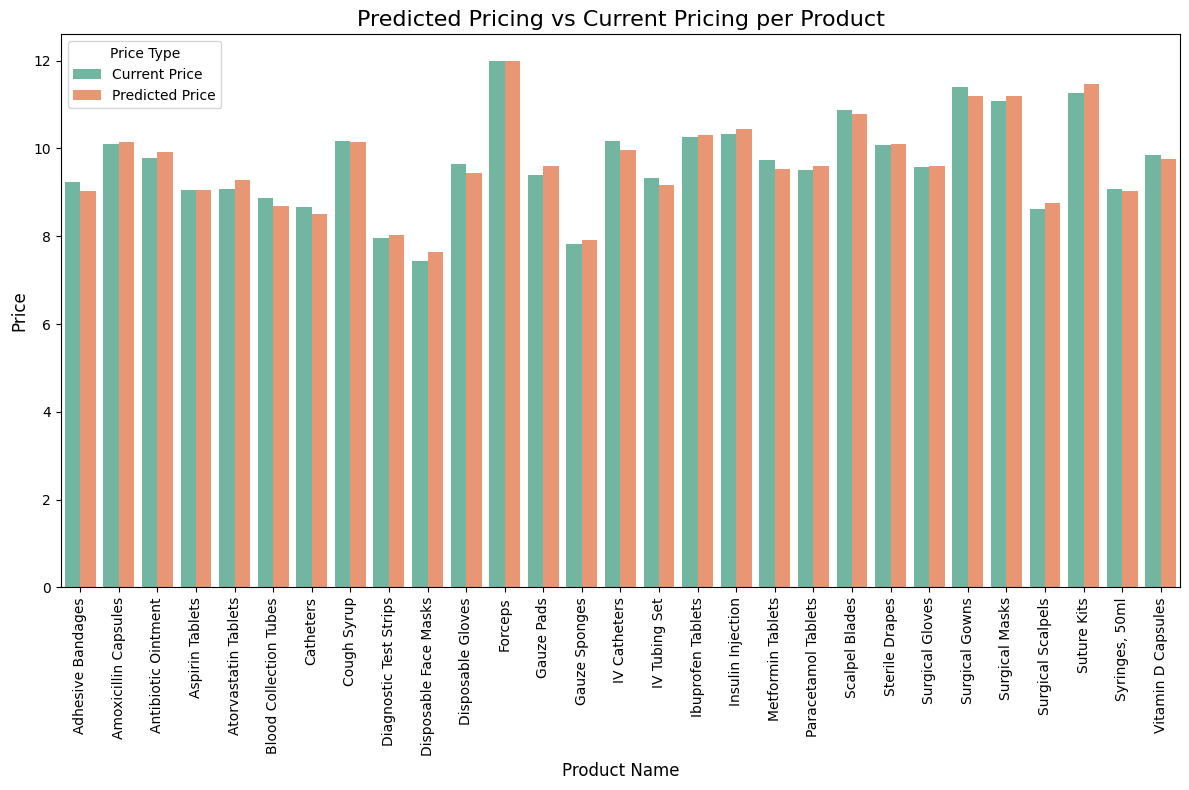

,product_name,current_price,predicted_price
0,Adhesive Bandages,9.24,9.04
1,Amoxicillin Capsules,10.09,10.14
2,Antibiotic Ointment,9.79,9.91
3,Aspirin Tablets,9.06,9.06
4,Atorvastatin Tablets,9.08,9.28
5,Blood Collection Tubes,8.87,8.69
6,Catheters,8.66,8.50
7,Cough Syrup,10.16,10.14
8,Diagnostic Test Strips,7.95,8.02
9,Disposable Face Masks,7.44,7.65


In [52]:
# Plot predicted vs average pricing

comparison = df.groupby("product_name").agg(
    current_price=("price_per_unit", "mean"),
    predicted_price=("predicted_price", "mean"),
).round(2).reset_index()

plt.figure(figsize=(12, 8))
comparison_melted = pd.melt(
    comparison, id_vars=["product_name"], value_vars=["current_price", "predicted_price"]
)

ax = sns.barplot(
    x="product_name",
    y="value",
    hue="variable",
    data=comparison_melted,
    palette="Set2",
)

plt.title("Predicted Pricing vs Current Pricing per Product", fontsize=16)
plt.xlabel("Product Name", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.xticks(rotation=90)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ["Current Price", "Predicted Price"], title="Price Type")

plt.tight_layout()
plt.show()

comparison

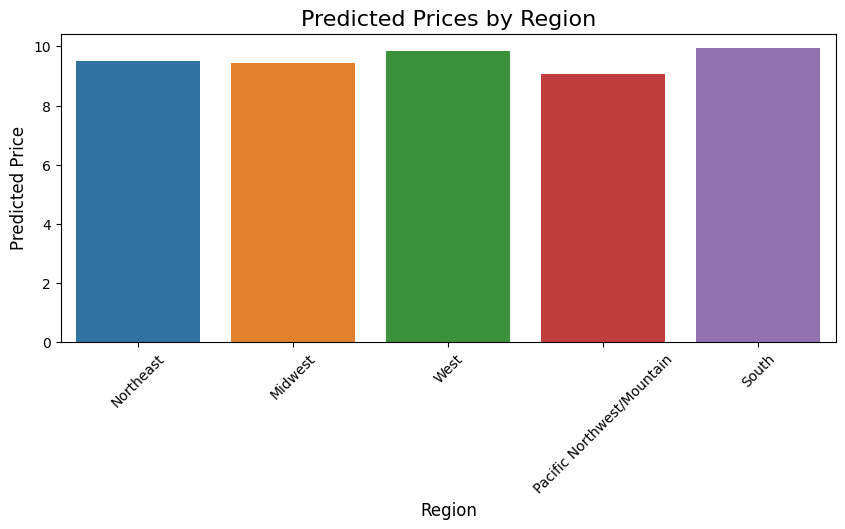

In [36]:
# Plot predicted prices by region

plt.figure(figsize=(10, 4))
sns.barplot(
    x="region", y="predicted_price", data=df, errorbar=None, hue="region"
)
plt.title("Predicted Prices by Region", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.xticks(rotation=45)
plt.show()

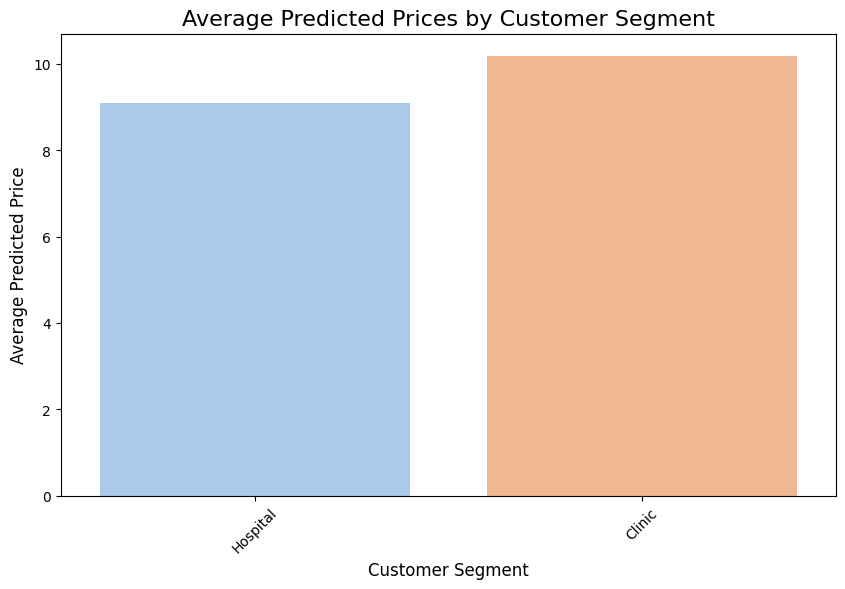

In [46]:
# Plot predicted prices by customer segment

plt.figure(figsize=(10, 6))
sns.barplot(
    x="customer_segment",
    y="predicted_price",
    data=df,
    errorbar=None,
    palette="pastel",
    hue="customer_segment",
    legend=False,
)
plt.title("Average Predicted Prices by Customer Segment", fontsize=16)
plt.xlabel("Customer Segment", fontsize=12)
plt.ylabel("Average Predicted Price", fontsize=12)
plt.xticks(rotation=45)
plt.show()